# Lectura y análisis de propiedades (ICF)
Notebook con funciones para leer HDF5, extraer propiedades, generar animaciones, cortes, cálculo de modos radiales promediados en H y en posiciones z0, y evolución temporal de dichos modos.
Geometría cilíndrica: X = H (altura, µm), Y = R (radio, µm).

# Diccionario de propiedades

# Funciones: lectura, extracción y visualización

In [1]:
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

# ============================================================
# Diccionario de propiedades
# ============================================================

propiedades = {
    0: "lower x edge [m]",
    1: "upper x edge [m]",
    2: "lower y edge [m]",
    3: "upper y edge [m]",
    4: "cell volume [m3]",
    5: "material temperature [eV]",
    6: "rad intensity group 1 [W/m2]",
    7: "rad intensity group 2 [W/m2]",
    8: "rad intensity group 3 [W/m2]",
    9: "rad intensity group 4 [W/m2]",
    10: "rad intensity group 5 [W/m2]",
    11: "rad intensity group 6 [W/m2]",
    12: "rad intensity group 7 [W/m2]",
    13: "rad intensity group 8 [W/m2]",
    14: "integrated radiation intensity [W/m2]",
    15: "volumetric energy source [W/m3]",
    16: "radiation temperature [eV]",
    17: "rho*Cv [J/m3/K]",
    18: "dT_emission"
}

# ============================================================
# Extraer propiedad y guardarla como .npy
# ============================================================

def extraer_propiedad(ruta_hdf5, indice_propiedad):
    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)
    os.makedirs(carpeta, exist_ok=True)

    with h5py.File(ruta_hdf5, "r") as f:
        datasets = sorted(
            [d for d in f if d.startswith("box_fine")],
            key=lambda x: int(x.split("_cy")[-1])
        )

        muestra = f[datasets[0]]
        Nt = len(datasets)
        Ny, Nx = muestra.shape[:2]

        data = np.zeros((Nt, Nx, Ny), dtype=np.float32)

        for i, ds in enumerate(datasets):
            tmp = f[ds][..., indice_propiedad]
            data[i] = tmp.T

    ruta_out = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.npy")
    np.save(ruta_out, data)
    print("✔ Guardado:", ruta_out)

    return ruta_out

def visualizar_propiedad(ruta_hdf5, indice_propiedad, fps=10, formato="mp4"):
    import numpy as np
    import h5py
    import os
    import matplotlib.pyplot as plt
    from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter

    # ----------------------------
    # Carpeta y archivo .npy
    # ----------------------------
    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_npy = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.npy")
    if not os.path.exists(ruta_npy):
        raise FileNotFoundError(
            f"No existe {ruta_npy}. Ejecuta primero extraer_propiedad."
        )

    data = np.load(ruta_npy)          # (Nt, Nz, Nr)
    Nt, Nz, Nr = data.shape

    # ----------------------------
    # Leer tiempos reales (LD)
    # ----------------------------
    tiempos_s = []
    with h5py.File(ruta_hdf5, "r") as f:
        for obj in f.values():
            if isinstance(obj, h5py.Dataset) and "time" in obj.attrs:
                tiempos_s.append(obj.attrs["time"][0])

    tiempos_s = np.array(tiempos_s, dtype=np.float64)

    if len(tiempos_s) != Nt:
        raise ValueError("Número de tiempos distinto al número de frames")

    if not np.all(np.diff(tiempos_s) > 0):
        raise ValueError("Este archivo no es LD (tiempos no monótonos)")

    tiempos_ns = tiempos_s * 1e9  # conversión correcta

    # ----------------------------
    # Rango de color fijo
    # ----------------------------
    vmin, vmax = np.percentile(data, [2, 98])
    cmap = "inferno"

    # ----------------------------
    # Figura
    # ----------------------------
    fig, ax = plt.subplots(figsize=(6, 5))

    im = ax.imshow(
        data[0],
        origin="lower",
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    ax.set_xlabel("r [µm]")
    ax.set_ylabel("z [µm]")

    nombre_prop = propiedades.get(
        indice_propiedad,
        f"prop_{indice_propiedad:02d}"
    )

    # Títulos (orden correcto)
    titulo_prop = ax.text(
        0.5, 1.10,
        nombre_prop,
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=14,
        weight="bold"
    )

    texto_tiempo = ax.text(
        0.5, 1.02,
        "",
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=11
    )

    plt.colorbar(im, ax=ax)

    # ----------------------------
    # Update
    # ----------------------------
    def update(i):
        im.set_data(data[i])
        texto_tiempo.set_text(f"t = {tiempos_ns[i]:.3f} ns")
        return im,

    anim = FuncAnimation(
        fig,
        update,
        frames=Nt,
        interval=1000 / fps,
        blit=False
    )

    # ----------------------------
    # Guardado
    # ----------------------------
    salida = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.{formato}")

    if formato == "gif":
        anim.save(salida, writer=PillowWriter(fps=fps))
    else:
        anim.save(salida, writer=FFMpegWriter(fps=fps))

    print("✔ Animación guardada:", salida)

# ============================================================
# Leer tiempos reales (LD) desde el HDF5
# ============================================================

def leer_tiempos(ruta_hdf5):
    tiempos = []
    with h5py.File(ruta_hdf5, "r") as f:
        for obj in f.values():
            if isinstance(obj, h5py.Dataset) and "time" in obj.attrs:
                tiempos.append(obj.attrs["time"][0])

    tiempos = np.array(tiempos, dtype=np.float64)

    if not np.all(np.diff(tiempos) > 0):
        raise ValueError("❌ El tiempo NO es monótono: este archivo no es LD")

    return tiempos  # en segundos

# ============================================================
# Índices temporales correctos (LD)
# ============================================================

def indices_por_tiempos_ns(tiempos_s, tiempos_ns_obj):
    """
    Devuelve los índices de tiempos más cercanos a los tiempos en ns que quieres.
    Funciona con tiempos uniformes o no uniformes.
    """
    tiempos_ns = tiempos_s * 1e9
    idx = []
    for t in tiempos_ns_obj:
        i = np.argmin(np.abs(tiempos_ns - t))
        idx.append(i)
    return np.array(idx, dtype=int)


# ============================================================
# Visualizar varios tiempos físicos (LD)
# ============================================================

def ver_propiedad_por_tiempos(
    ruta_hdf5,
    indice_propiedad,
    tiempos_ns_objetivo,
    vmin=None,
    vmax=None
):
    base = os.path.basename(ruta_hdf5)
    nombre = os.path.splitext(base)[0]
    carpeta = os.path.join(os.path.dirname(ruta_hdf5), nombre)

    ruta_npy = os.path.join(carpeta, f"prop_{indice_propiedad:02d}.npy")
    if not os.path.exists(ruta_npy):
        raise FileNotFoundError("Ejecuta primero extraer_propiedad")

    data = np.load(ruta_npy)  # (Nt, Nz, Nr)

    tiempos_s = leer_tiempos(ruta_hdf5)
    idx = indices_por_tiempos_ns(tiempos_s, tiempos_ns_objetivo)

    frames = data[idx]

    if vmin is None or vmax is None:
        vmin, vmax = np.percentile(frames, [2, 98])

    n = len(idx)
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4), constrained_layout=True)

    if n == 1:
        axes = [axes]

    nombre_prop = propiedades.get(indice_propiedad, f"prop_{indice_propiedad:02d}")

    for ax, i, t in zip(axes, idx, tiempos_ns_objetivo):
        im = ax.imshow(
            data[i],
            origin="lower",
            cmap="inferno",
            vmin=vmin,
            vmax=vmax
        )
        ax.set_title(f"t = {t:.3f} ns")
        ax.set_xlabel("r [µm]")
        ax.set_ylabel("z [µm]")

    cbar = fig.colorbar(im, ax=axes, shrink=0.85)
    cbar.set_label(nombre_prop)

    fig.suptitle(nombre_prop, fontsize=14, weight="bold")
    plt.show()


# Celdas finales para ejecución rápida y demostración

SACAR PROPIEDADES DE UNA RUTA

✔ Guardado: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LDrad\prop_14.npy
✔ Animación guardada: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LDrad\prop_14.mp4
✔ Guardado: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LDrad\prop_16.npy
✔ Animación guardada: C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LDrad\prop_16.mp4


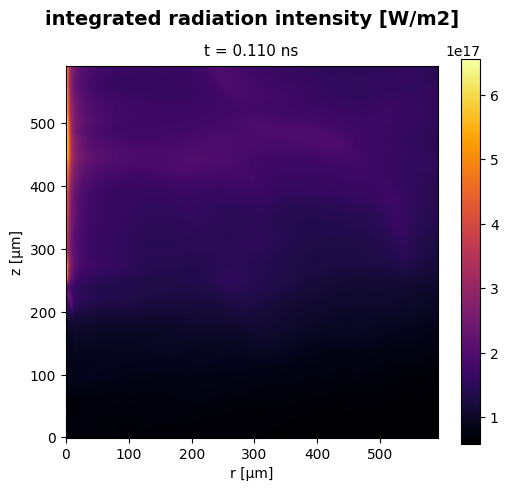

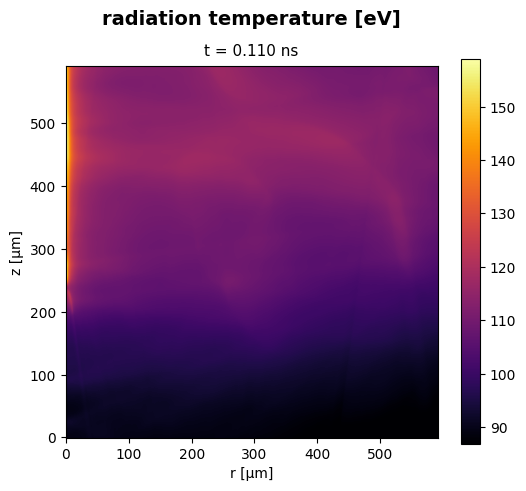

In [6]:
# Ajusta estas rutas/variables a tu entorno
ruta_hdf5 = r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\20_LDrad.h5"
indice = [14,16]


for i in indice:

    ruta_npy = extraer_propiedad(ruta_hdf5, i)
    visualizar_propiedad(ruta_hdf5, i)


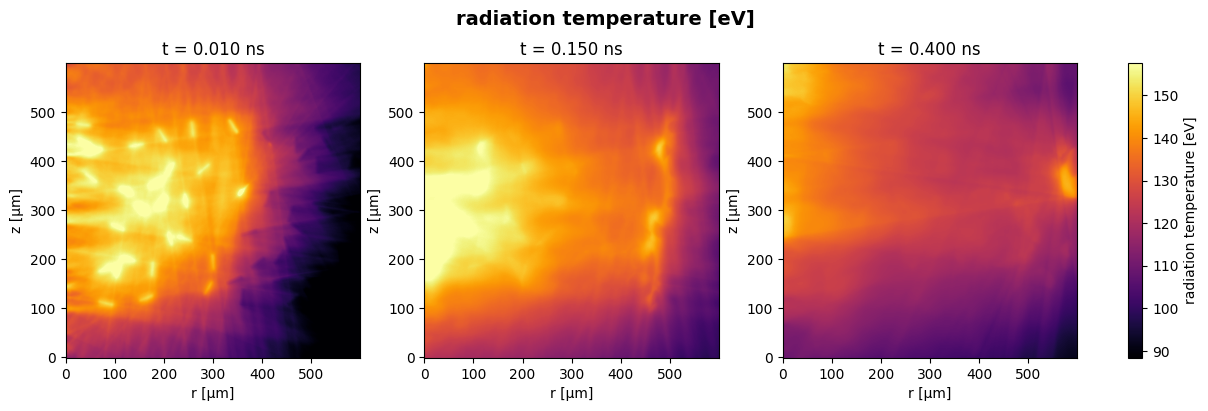

In [5]:
# LoW DENSITY

indice_propiedad= 16

# Carpeta y HDF5
ruta_hdf5 = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_LDrad.h5"]
t_ns = [ 0.01, 0.15, 0.4]

for r in ruta_hdf5:
    ver_propiedad_por_tiempos(
        r,
        indice_propiedad,
        tiempos_ns_objetivo= t_ns,
    )

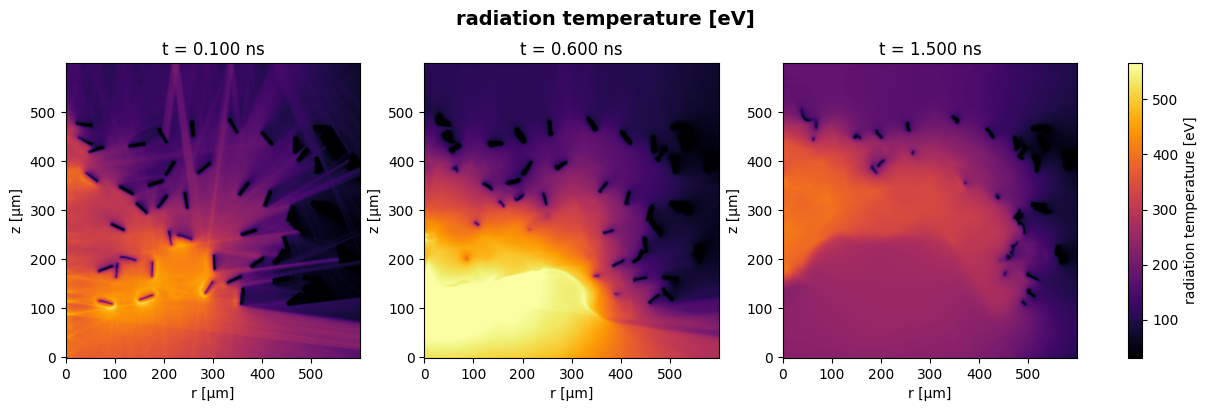

In [3]:
# HIGH DENSITY

indice_propiedad= 16

# Carpeta y HDF5
ruta_hdf5 = [r"C:\Users\34620\Documents\TFM\Hdf5 Output ARWEN\50_HDrad.h5"]
t_ns2 = [ 0.1, 0.6, 1.5]
t_ns = [ 0.2, 0.8, 1.8]

for r in ruta_hdf5:
    ver_propiedad_por_tiempos(
        r,
        indice_propiedad,
        tiempos_ns_objetivo= t_ns2,
    )